# Time Series - Forecasting Stock Prices


This dataset consists of monthly average stock closing prices of Apple over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the Transformer model in order to **predict the stock closing price of APPAL.**

### Importing libraries

In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [2]:
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [3]:
# Only the closing price

df= df[['Date','Close']]

In [4]:
df.head()

,Date,Close
0,2006-01-03,10.68
1,2006-01-04,10.71
2,2006-01-05,10.63
3,2006-01-06,10.90
4,2006-01-09,10.86


In [5]:
df.describe()

,Close
count,3019.000000
mean,64.662892
std,44.536448
min,7.240000
25%,23.420000
50%,57.920000
75%,99.480000
max,176.420000


In [6]:
df.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

In [7]:
df.head()

,date,close
0,2006-01-03,10.68
1,2006-01-04,10.71
2,2006-01-05,10.63
3,2006-01-06,10.90
4,2006-01-09,10.86


### Checking info 

In [8]:
# Check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3019 non-null   object 
 1   close   3019 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.3+ KB


In [9]:
# Setting date as the index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


**visualize the time series** to get an idea how about the trend and/or seasonality within the data.

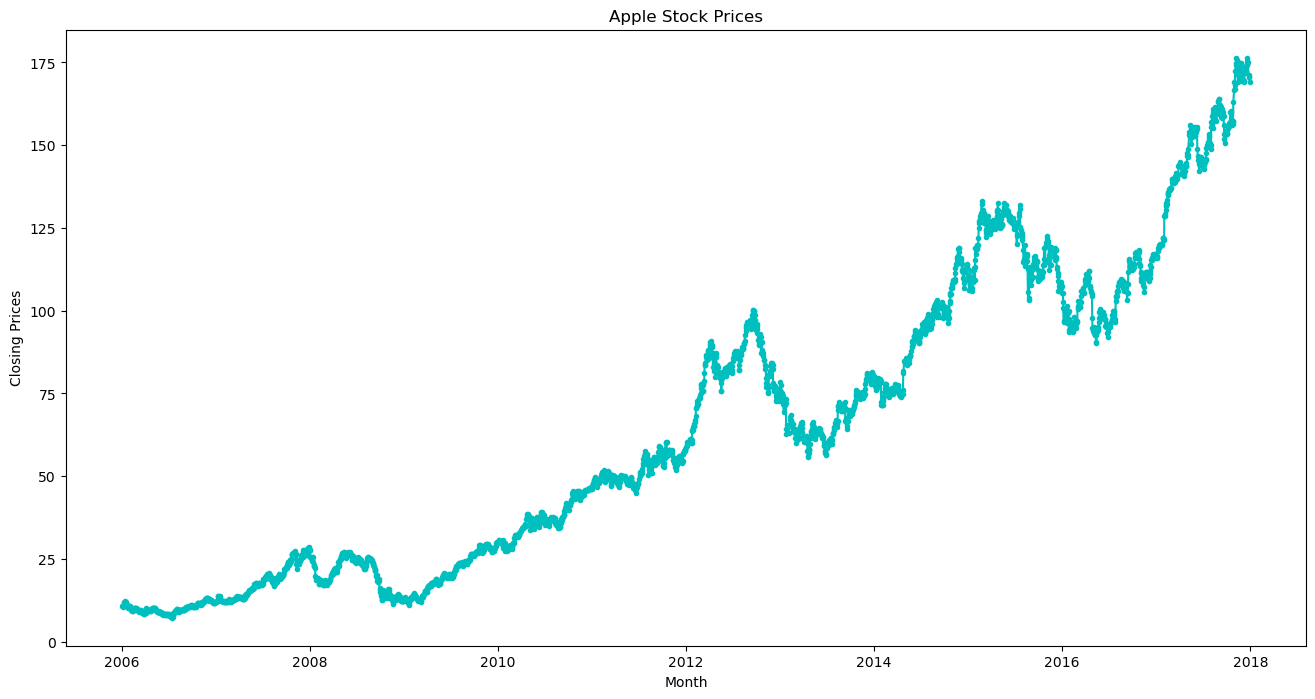

In [10]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Apple Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

### Splitting the dataset

In [11]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-03   10.68
2006-01-04   10.71
2006-01-05   10.63
2006-01-06   10.90
2006-01-09   10.86
...            ...
2015-11-24  118.88
2015-11-25  118.03
2015-11-27  117.81
2015-11-30  118.30
2015-12-01  117.34

[2495 rows x 1 columns]
             close
date              
2016-01-04  105.35
2016-01-05  102.71
2016-01-06  100.70
2016-01-07   96.45
2016-01-08   96.96
...            ...
2017-11-27  174.09
2017-11-28  173.07
2017-11-29  169.48
2017-11-30  171.85
2017-12-01  171.05

[484 rows x 1 columns]


### Testing the stationary of the series

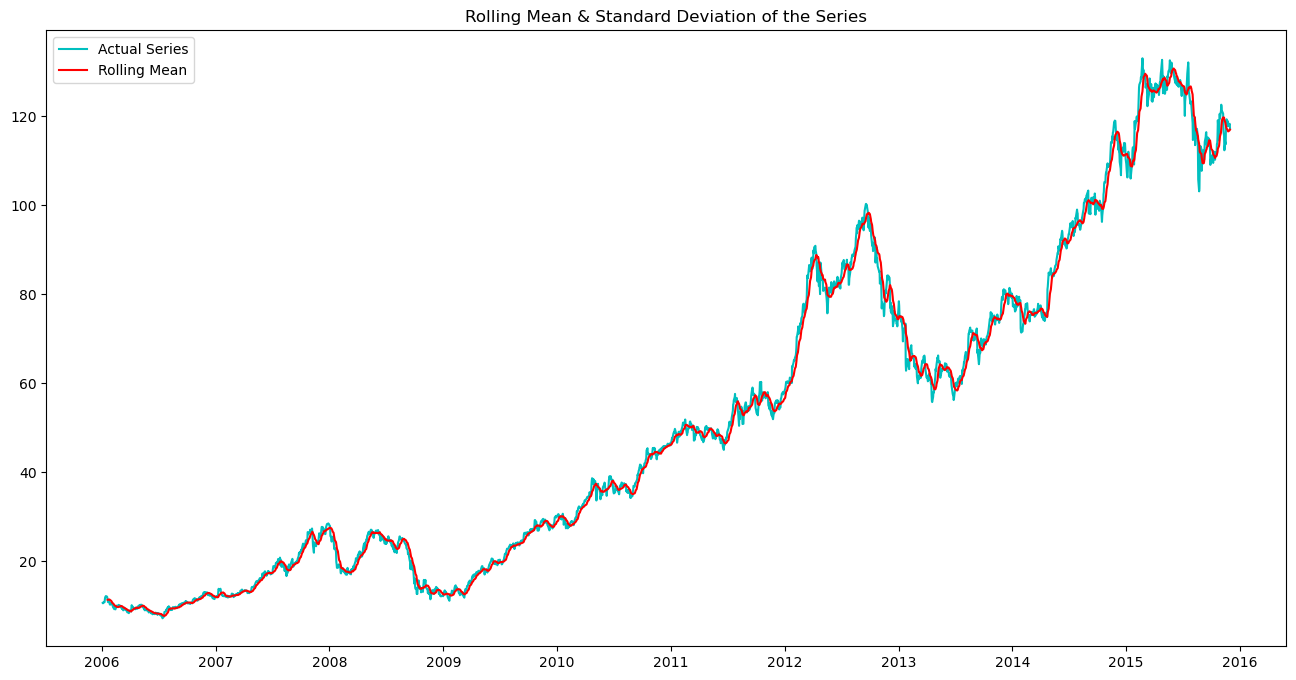

In [12]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

In [13]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            -0.095494
p-value                    0.949885
Lags Used                 20.000000
No. of Observations     2474.000000
Critical Value (1%)       -3.432996
Critical Value (5%)       -2.862709
Critical Value (10%)      -2.567392
dtype: float64


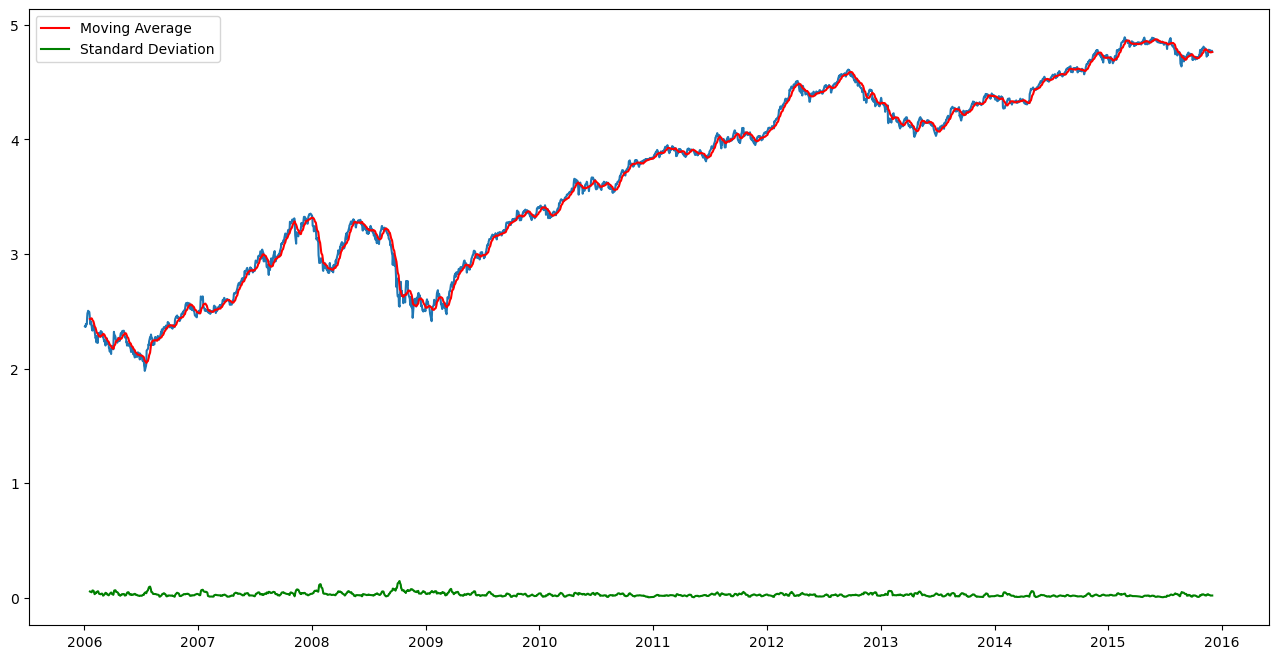

In [14]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

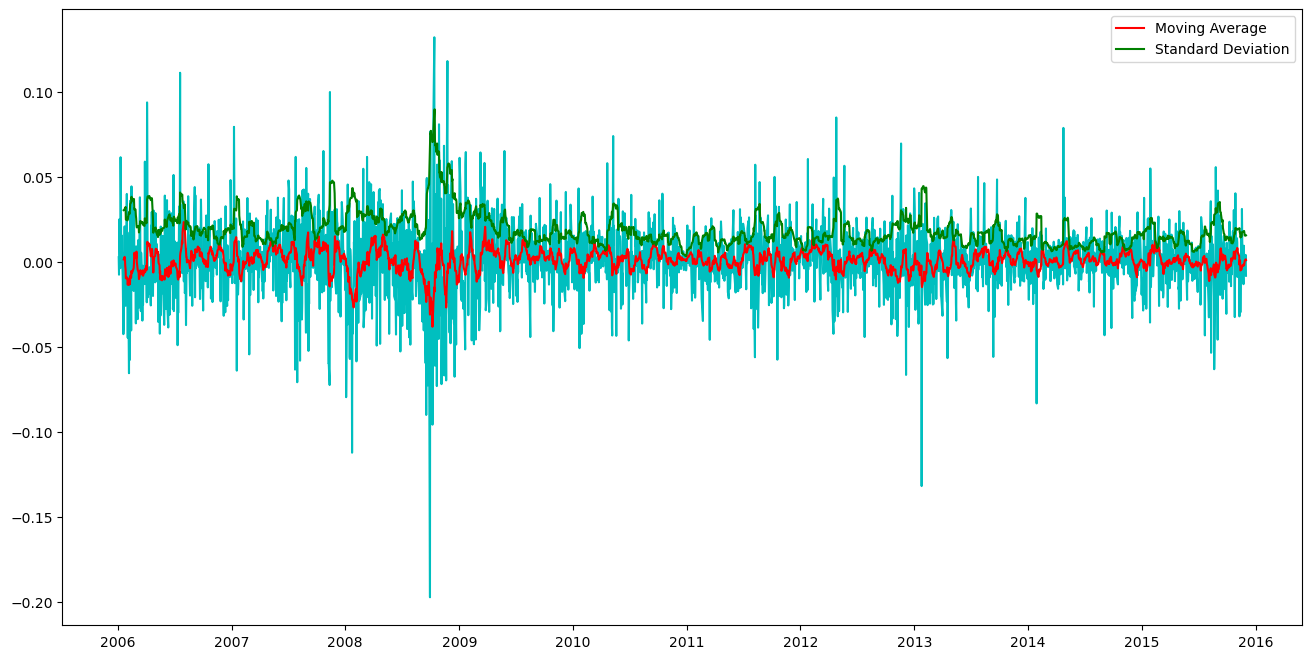

In [15]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:**
- **The mean and the standard deviation seem to be constant over time.**

Let us use the adfuller test to check the stationarity.

In [16]:
#____________________ # call the adfuller function for df_shift series
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -20.498872
p-value                    0.000000
Lags Used                  5.000000
No. of Observations     2488.000000
Critical Value (1%)       -3.432981
Critical Value (5%)       -2.862702
Critical Value (10%)      -2.567389
dtype: float64


### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR

<Figure size 1600x800 with 0 Axes>

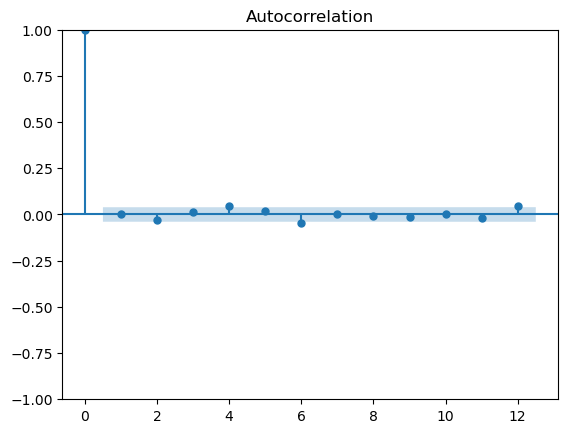

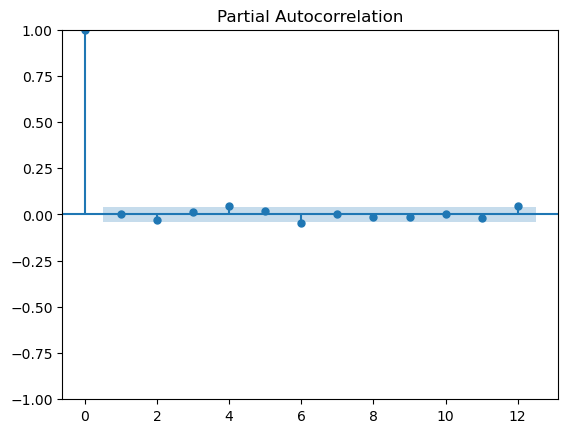

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

from sklearn.preprocessing import MinMaxScaler

# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_shift.values.reshape(-1, 1))

# Splitting data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Function to prepare data for LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshaping into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 4
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  
  # Creates a single transformer block
  
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  
  # Developing the model adding many transformer blocks

  n_timesteps, n_features, n_outputs = 4, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [19]:
# transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [20]:
# transformer.summary()

In [21]:
def fit_transformer(transformer: tf.keras.Model, lr, optimizer, loss_function):
  
  # Compiles and fits with the transformer
  
  optimizer = optimizer(learning_rate=lr)
  transformer.compile(
    loss=loss_function,
    optimizer= optimizer,
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist

Learning Rate: 0.001, Optimizer: <class 'keras.optimizers.adam.Adam'>, Loss function: mse,  Dropout: 0.1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 4, 1)        3585        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0

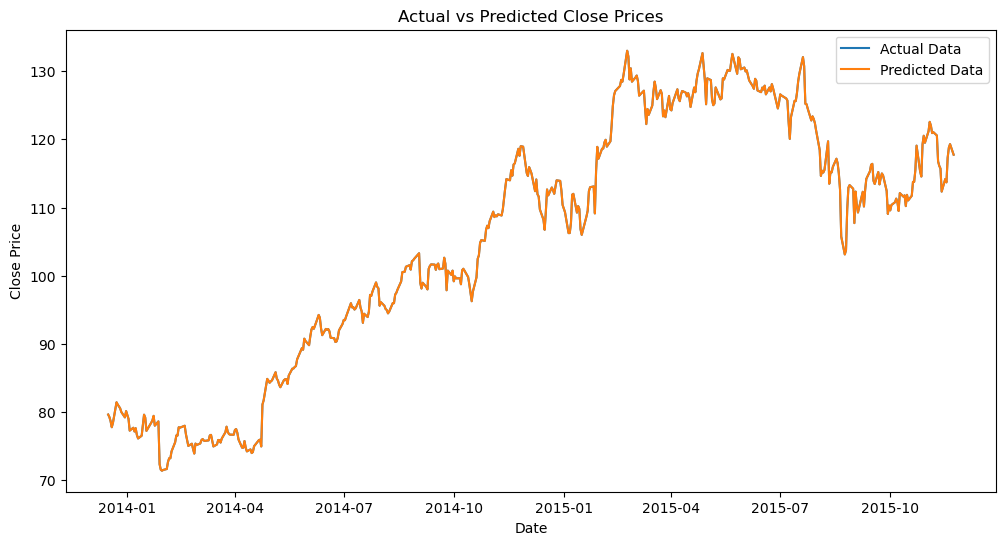

Learning Rate: 0.001, Optimizer: <class 'keras.optimizers.adam.Adam'>, Loss function: mse,  Dropout: 0.2
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 4, 1)        2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 4, 1)        3585        ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization

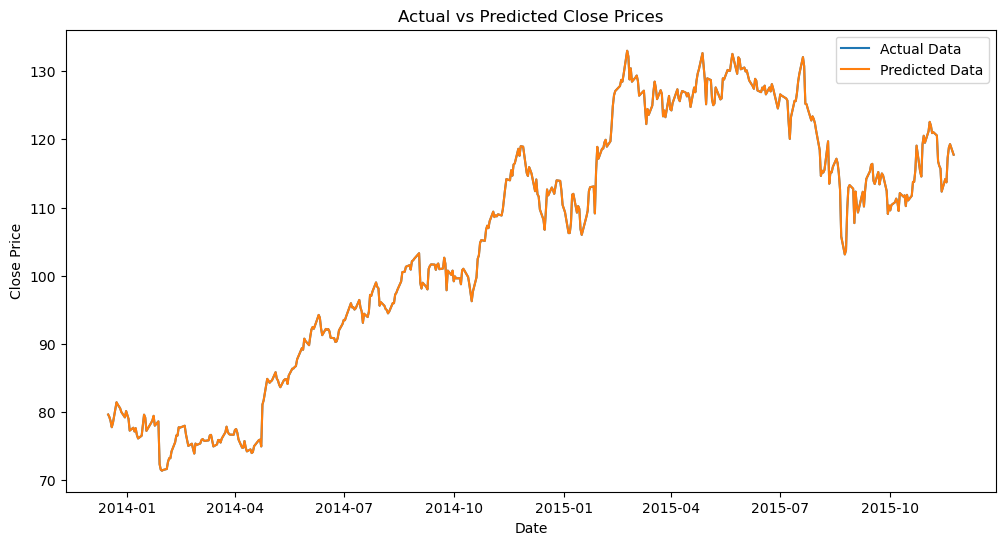

Learning Rate: 0.001, Optimizer: <class 'keras.optimizers.adam.Adam'>, Loss function: mse,  Dropout: 0.3
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 4, 1)        2           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 4, 1)        3585        ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization

In [22]:
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
loss_functions = ["mse", "mae", tf.keras.losses.Huber()]
learning_rates = [0.001, 0.005, 0.01]
dropout_rates = [0.1, 0.2, 0.3]

for opt in optimizers:
    for lr in learning_rates:
        for loss in loss_functions:
            for dropout_rate in dropout_rates:
                print(f"Learning Rate: {lr}, Optimizer: {opt}, Loss function: {loss},  Dropout: {dropout_rate}")
                transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=dropout_rate, attention_axes=1)
                transformer.summary()
                hist = fit_transformer(transformer, lr=lr, optimizer = opt, loss_function = loss)
                
                train_predict = transformer.predict(X_train)
                test_predict = transformer.predict(X_test)
                
                # Inverse transforming the predictions to the original scale
                train_predict = scaler.inverse_transform(train_predict)
                test_predict = scaler.inverse_transform(test_predict)

                # Shifting the predictions to the original time frame
                train_predict_rnn = train_predict + np.exp(df_log[0+5:train_size].shift(periods=1).values)
                test_predict_rnn = test_predict + np.exp(df_log[train_size+5+1:].shift(periods= 4+1).values)
                
                print("Test LSTM model RMSE:", np.sqrt(mean_squared_error(df['close'].iloc[train_size + 5 + 1:train_size + len(test_predict_rnn) + 1].to_list(), test_predict_rnn[5:])))
                
                plt.figure(figsize=(12, 6))
                plt.plot(df.index[train_size+5+1:train_size+len(test_predict)+1], df['close'].iloc[train_size+5+1:train_size+len(test_predict)+1], label='Actual Data')
                plt.plot(df.index[train_size+5+1:train_size+len(test_predict)+1], test_predict_rnn[5:], label='Predicted Data')
                plt.xlabel('Date')
                plt.ylabel('Close Price')
                plt.title('Actual vs Predicted Close Prices')
                plt.legend()
                plt.show()
            